In [1]:
import shutil
import torch
import torch.nn as nn
import torchvision
import numpy as np
import sys
import os 
torch.manual_seed(100)
np.random.seed(100)
import compress_entropy
import generateCompressionImages
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
from JPEGAndEntropyEncoding import *
import matplotlib.pyplot as plt
from PIL import Image
import os

path_to_image = "../../Data/Kodak/kodim23.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = compress_entropy.Compress().to(device).to(memory_format=torch.channels_last)


model.load_state_dict(torch.load("./CE_L1_15/Checkpoints/CE_L1_15_22_checkpoint.pt")['state_dict'])
def compress_and_show_image(image):
    
    image = image.permute(2,0,1)
    b = image
    a = model(torch.multiply(torch.add(torch.unsqueeze(image,0),-128),1/128))


    a = torch.squeeze(a)
    a = a.permute(1,2,0)
    a = torch.add(torch.multiply(a,128), 128)
    a = a.detach().cpu().numpy()
    np.clip(a, a_min=0, a_max=255, out=a)
    a = np.rint(a)
    a = a.astype(np.uint8)

    b = torch.squeeze(b)
    b = b.permute(1,2,0)
    b = b.detach().cpu().numpy()
    np.clip(b, a_min=0, a_max=255, out=b)
    b = np.rint(b)
    b = b.astype(np.uint8)


    f, ax = plt.subplots(1,2,figsize=(15, 30))
    ax[0].imshow(a)
    ax[1].imshow(b)
    plt.show()
    
    
def compress_and_encode(image):
    image = image.permute(2,0,1)
    a = model(torch.multiply(torch.add(torch.unsqueeze(image,0),-128),1/128))
    latent_layer = model.encode(a)
    return len(arith_encode_latent_layer(latent_layer.flatten(),"KodimTests/testcompression")) / 8

def JPEG_compress_and_decompress_image(im,qf,subsampling = "Down444"):
    im = np.array(im)
    res = JPEGcompress_and_decompress(im,qf,subsampling)
    return Image.fromarray(np.array(res,dtype=np.uint8))

def JPEG_get_compress_to_file(im,qf,name):
    JPEG_compress_to_file(np.array(im),qf,"Down444","temp")
    s = os.stat("temp").st_size
    rate = "{:03d}".format(int(s / (512 * 768 * 3) * 10000))
    file_name = name + "qf_" + str(qf) + "_rate_" + rate[0] + "_" + rate[1:] + ".png"
    im.save(file_name,"PNG")

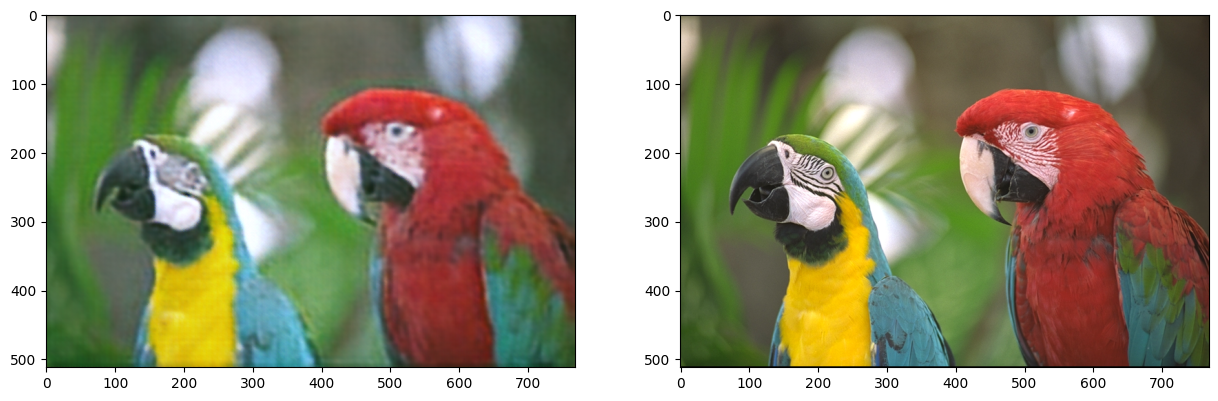

In [2]:
image = torchvision.io.image.read_image(path_to_image).permute(1,2,0).to(device="cuda", dtype=torch.float32)
compress_and_show_image(image)


In [3]:
size = compress_and_encode(image)
image_size = 512 * 768 * 3
size/image_size,size

(0.09345160590277778, 110240.0)

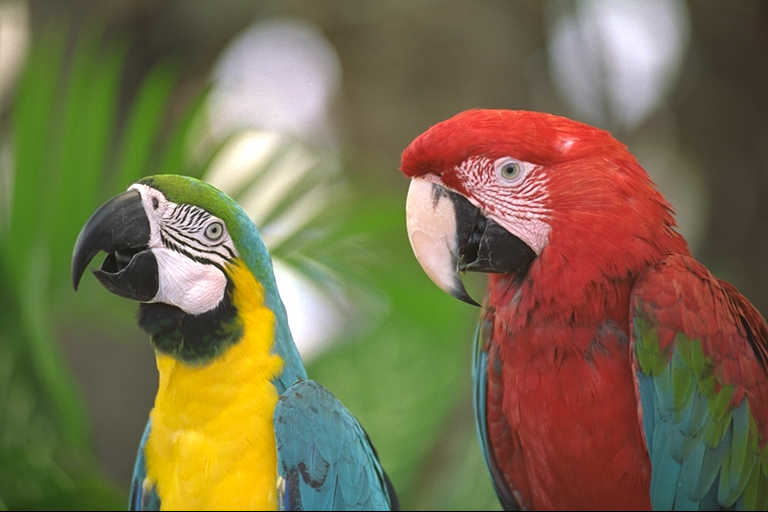

In [4]:
im = Image.open(path_to_image)
JPEG_compress_and_decompress_image(im,50)